# Comparison between TPOT and GAMA

In order to see if GAMA does indeed function 'normally', we test it on a set of problems and see how well it does compared to TPOT. We expect to see very similar results as GAMA is more or less a reimplementation of TPOT at this point.

We test two versions of GAMA, GAMA-GEN and GAMA-Async. The first uses a generation-based algorithm (mu+lambda), which is the same as TPOT uses. The second uses an asynchronous algorithm instead.

All experiments are conducted single-core. This also means that one of the benefits of an asynchronous algorithm, the slack of synchronization between threads/processes, does not come into play.

For each experiment ((dataset, method)-combination), 5-fold CV was repeated 3 times. The population was of size 40, optimization metrics were accuracy and pipeline length.

In [47]:
import pickle
import os

import pandas as pd
import numpy as np

In [32]:
merged_results_path = 'first_check_results.csv'
if os.path.exists(merged_results_path):
    df = pd.read_csv(merged_results_path)
else:
    # Merge separate output files.
    total_df = None
    for tid in [167120, 167141, 146820, 219, 43, 4534, 34537, 14965, 1487, 3]:
        for fold in range(5):
            for seed in range(1,4):
                for method in ['tpot', 'gamagen', 'gama_async']:
                    file_name = 'gama_tpot_comparison/results/results_{}_{}_{}_{}.pkl'.format(seed, tid, fold, method)
                    if os.path.exists(file_name):
                        with open(file_name, 'rb') as fh:
                            results = pickle.load(fh)
                        results['time_per_ind'] = results['time']/results['n_inds']
                        results['seed'] = seed
                        del results['generations']
                        if total_df is not None:
                            total_df = pd.concat([total_df, results], ignore_index=True)
                        else:
                            total_df = results
    total_df.to_csv(merged_results_path, index=False)
    df = total_df

In [33]:
df.groupby(by=['task','seed','name',]).mean().head(18)

fold  population     score         time  n_inds  \
task seed name                                                          
3    1    gama_async   2.0        40.0  0.993431  3601.088923  1085.0   
          gamagen      2.0        40.0  0.992178  3600.829085  1330.0   
          tpot         2.0        40.0  0.995932  3647.834416   496.0   
     2    gama_async   2.0        40.0  0.991239  3600.764213   948.4   
          gamagen      2.0        40.0  0.994056  3605.050794   921.4   
          tpot         2.0        40.0  0.996246  3657.585653   428.8   
     3    gama_async   2.0        40.0  0.996245  3601.532837   906.0   
          gamagen      2.0        40.0  0.995306  3605.438868  1012.6   
          tpot         2.0        40.0  0.997184  3619.385228   410.2   
43   1    gama_async   2.0        40.0  0.951967  3600.662722   797.6   
          gamagen      2.0        40.0  0.953487  3600.671572   825.8   
          tpot         2.0        40.0  0.954356  3646.386521   271.0   
     2    gama_async   2.0        40.0  0.946970  3600.465777   790.2   
          gamagen      2.0        40.0  0.952617  3600.672243   813.2   
          tpot         2.0        40.0  0.950229  3624.314015   240.0   
     3    gama_async   2.0        40.0  0.951750  3600.395832   928.4   
          gamagen      2.0        40.0  0.953704  3600.751756   894.4   
          tpot         2.0        40.0  0.953054  3658.973177   285.0   

                      time_per_ind  
task seed name                      
3    1    gama_async      3.398503  
          gamagen         2.740130  
          tpot            7.645747  
     2    gama_async      4.090571  
          gamagen         4.403311  
          tpot            8.853690  
     3    gama_async      4.185436  
          gamagen         3.713538  
          tpot            8.925534  
43   1    gama_async      4.711134  
          gamagen         4.536037  
          tpot           14.457898  
     2    gama_async      5.571041  
          gamagen         4.814965  
          tpot           15.477560  
     3    gama_async      3.980040  
          gamagen         4.330911  
          tpot           13.805223

At first glance, results are very similar. In terms of time used, GAMA seems to stick closer to the allowed hour (3600 seconds). Aggregating over all experiments, we see this holds true in general as well (though GAMA too exceeds the limits a worrying amount). 

In [48]:
df.groupby("name").agg({"time": [np.mean, np.std, np.max]})

time                        
                   mean        std         amax
name                                           
gama_async  3602.466312   5.338028  3645.921539
gamagen     3604.102758  10.053822  3678.101938
tpot        3638.861777  56.865777  3891.101184

We also see that the total number of individuals evaluated, or the time used per individual is respectively much higher/lower in GAMA than in TPOT. Possible reasons (I do not know if any are true):
* GAMA creates more invalid pipelines, resulting in quick-to-evaluate but useless pipelines (discarded immediately).
* TPOT has more overhead than GAMA.
* TPOT's slightly more expansive configuration lead to slower average pipelines.

If the last case holds true, this could also explain the difference in stop-delay. GAMA and TPOT both use the `stopit` module to abort the algorithm when the maximum allowed time is exceeded. This module raises an Exception after time is exceeded. If I understand correctly, Python Exceptions are only processed when control is returned to the Python interpreter. Scikit-learn algorithms are mostly optimized C-code, meaning they run outside of the Python interpreter. This means that evaluation of pipelines can only be aborted at specific points (e.g. between pipeline components). If components are slower to run, there will be a bigger delay before aborting.

As we will see below, not all experiments are completed. TPOT and GAMA-Gen were run on all tasks. GAMA-Async was not run on the tasks were either GAMA-Gen or TPOT did not complete (i.e. task 4534 and 167120). I will try to determine why those methods did not complete, and rerun the experiments if it is easily fixed.

In [36]:
df.groupby(by=['task','name']).count().fold

task    name      
3       gama_async    15
        gamagen       15
        tpot          15
43      gama_async    15
        gamagen       15
        tpot          15
219     gama_async    15
        gamagen       15
        tpot          15
4534    tpot          15
14965   gama_async    15
        gamagen       15
        tpot          15
34537   gama_async    15
        gamagen       15
        tpot          15
146820  gama_async    15
        gamagen       15
        tpot          15
167120  gamagen        8
167141  gama_async    15
        gamagen       15
        tpot          14
Name: fold, dtype: int64

We may also note that TPOT did not evaluate one fold on task 167141.

In [64]:
nmethods_by_task = df.groupby(by=['task']).name.nunique()
tasks_with_three_methods = [t for t, n in zip(nmethods_by_task.index, nmethods_by_task) if n == 3]

We will now compare the obtained scores from the three different methods GAMA-async (green), GAMA-gen (orange) and TPOT (purple). Each dot in the scatter plot represents one average score from a 5-fold CV experiment. 

To give context, the best accuracy score found from *any* OpenML run for that task is also shown as a red line. **However** take this with a grain of salt as there are big differences here, most important:
* It is the best score picked out of (tens of) thousands of runs. I expect these scores to be more optimistic than the AutoML scores.
* They are based on 10-fold CV, whereas our scores are based on 5-fold CV. Our scores might exhibit more variance, and are trained on less data each.

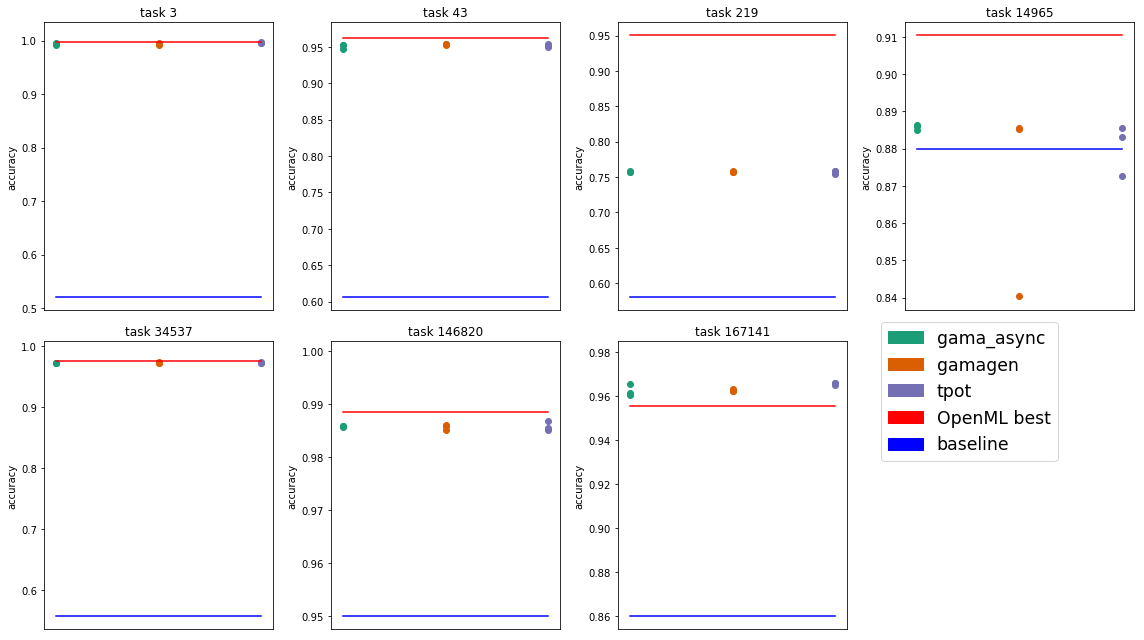

In [134]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

include_oml = True

%matplotlib inline

color_map = dict(gama_async='#1b9e77', gamagen='#d95f02', tpot='#7570b3')
oml_best = {3: (0.9981, 0.52, 3196, 37), 43:(0.9626, 0.606, 4601, 58), 219:(0.9501, 0.58, 45312, 9), 14965:(0.9104, 0.88, 45211, 17),
            34537:(0.9751, 0.5569, 11055, 31), 146820:(0.9886, 0.95, 4839,6), 167141: (0.9556, 0.86, 5000, 21)} # max acc, n_samples, n_features
fig = plt.figure(figsize=(16,9))

for i, task in enumerate(tasks_with_three_methods):
    ax = fig.add_subplot(2, 4, 1+i)
    ax.set_title('task {}'.format(task))
    ax.set_ylabel('accuracy')
    ax.get_xaxis().set_visible(False)
    df_task = df[df.task == task]
    df_grouped = df_task.groupby(['name','seed'], as_index=False).mean()
    
    for i, (method, color) in enumerate(color_map.items()):
        scores = df_grouped[df_grouped.name == method].score
        ax.scatter([i]*len(scores), scores, c=color)
        
    if include_oml:
        ax.plot(range(len(scores)), [oml_best[int(task)][0]]* len(scores), c='r')
        ax.plot(range(len(scores)), [oml_best[int(task)][1]]* len(scores), c='b')
    

axes[-1].set_visible(False)
patches = [Patch(color=color) for color in color_map.values()]
keys = list(color_map.keys())
if include_oml:
    patches += [Patch(color='r'), Patch(color='b')]
    keys += ['OpenML best','baseline']
    
plt.figlegend(patches,
              keys,
              loc=(0.77, 0.28),
              fontsize='xx-large')
plt.tight_layout()

(*note*: You can set `include_oml` to `False` to avoid plotting OpenML best and baseline)

Comparing between the methods, I don't think there are any clear-cut conclusions to be had from these results, other than that they still seem very similar.

When comparing to OpenML scores, keep the differences in evaluation pointed out earlier in mind.
Two tasks stand out, for different reasons: task 219 and 167141.

In task 219, the methods score much worse than OpenML flows.
The OpenML results are not outliers, there are many different flows which achieve similar performance (openml.org/t/219).
Looking at the data, it seems that I made a mistake and selected a time-series dataset that was treated as iid data in validation.
I decided to keep/share the results anyway, as they do at least signify that the methods themselves score similarly in this botched-up scenario :)

For task 167141, it seems there are very few Flows tried on OpenML (only 4, still totalling almost 3000 runs). Some specific preprocessing step, or a particular algorithm could be used that is not present in any of the Flows. This could be a reasonable explanation as to why AutoML systems beat the best Flow.

Finally, in task 14965, we can see that both TPOT and GAMA-gen have a run that performs worse than a baseline majority class classifier. I am not sure what we can learn from this.

A final note is that I should be more careful selecting Benchmark datasets. I had initially looked for more balanced datasets (as I would be using accuracy as optimization metric). However, I think that when I narrowed down my filter to 'bigger' datasets, I might have dropped the requirement for reasonable balance. I am not sure if it affected my study too much (as the main goal was to compare GAMA/TPOT).

## Conclusion
In my opinion, GAMA passed the sanity check. It seems to perform well enough to go through more extensive evaluation.
However, the analysis still raised a few questions and points of improvement. They include:
* Why does GAMA evaluate individuals faster? Look at the number of invalid pipelines in each method.
* Why did GAMA-gen not evaluate on all folds on task 167120, or on any fold on task 4534?
* Why did TPOT not evaluate on any fold of task 167120?
* Be more careful when selecting benchmark datasets.